## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/caco/caco_klek_train.csv")
df_test = pd.read_csv("../../data/train/caco/caco_klek_test.csv")
df_valid = pd.read_csv("../../data/train/caco/caco_klek_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'permeability']
y_train = df_train_all['permeability']

X_test = df_test.loc[:, df_test.columns != 'permeability']
y_test = df_test['permeability']

In [5]:
X_train.shape, y_train.shape

((2811, 4860), (2811,))

In [6]:
X_test.shape, y_test.shape

((704, 4860), (704,))

## 3. Remove low variance features

In [7]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,KRFP1,KRFP2,KRFP10,KRFP14,KRFP16,KRFP17,KRFP18,KRFP19,KRFP20,KRFP25,...,KRFP4826,KRFP4827,KRFP4828,KRFP4829,KRFP4830,KRFP4835,KRFP4843,KRFP4853,KRFP4857,KRFP4858
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
4,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
347,1,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
348,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
349,1,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_test

,KRFP1,KRFP2,KRFP10,KRFP14,KRFP16,KRFP17,KRFP18,KRFP19,KRFP20,KRFP25,...,KRFP4826,KRFP4827,KRFP4828,KRFP4829,KRFP4830,KRFP4835,KRFP4843,KRFP4853,KRFP4857,KRFP4858
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
700,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,1,0,0
701,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# write
idxs_dict = {
    'caco': idxs.tolist()
}

with open('../../klek_idxs.txt', 'w') as json_file:
    json.dump(idxs_dict, json_file)

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [10]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [11]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'cholesky', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 14.1750918132906
MSE: 700.9695224698179
RMSE: 26.4758290232774
R2 Square 0.32306785516469516 

Base model:
MAE: 14.510459733088357
MSE: 816.0888608296586
RMSE: 28.567269047454616
R2 Square 0.21189614494058406 

Train set:
Tuned model:
MAE: 11.897368121522199
MSE: 450.29635580554003
RMSE: 21.220187459245974
R2 Square 0.48108970560899766 

Base model:
MAE: 12.671120675871032
MSE: 559.6507577753737
RMSE: 23.6569388927514
R2 Square 0.3550724190209096 



In [12]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [17]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 8],
    'n_estimators': [500, 1000, 1500, 2500],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 8, 'n_estimators': 2500} 

Test set:
Tuned model:
MAE: 12.766681488195104
MSE: 648.9694004329583
RMSE: 25.474877829598288
R2 Square 0.37328480898899596 

Base model:
MAE: 11.350675902068373
MSE: 588.8907044641655
RMSE: 24.267070372506144
R2 Square 0.43130330939079364 

Train set:
Tuned model:
MAE: 10.673369629528414
MSE: 282.955827467513
RMSE: 16.821290897773363
R2 Square 0.673928758610197 

Base model:
MAE: 8.53213895722157
MSE: 198.85553133593837
RMSE: 14.101614493948498
R2 Square 0.770843843223611 



In [18]:
params = {'max_depth': 8, 'n_estimators': 2500} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 12.766681488195104
MSE: 648.9694004329583
RMSE: 25.474877829598288
R2 Square 0.37328480898899596 

Train set:
MAE: 10.673369629528414
MSE: 282.955827467513
RMSE: 16.821290897773363
R2 Square 0.673928758610197 



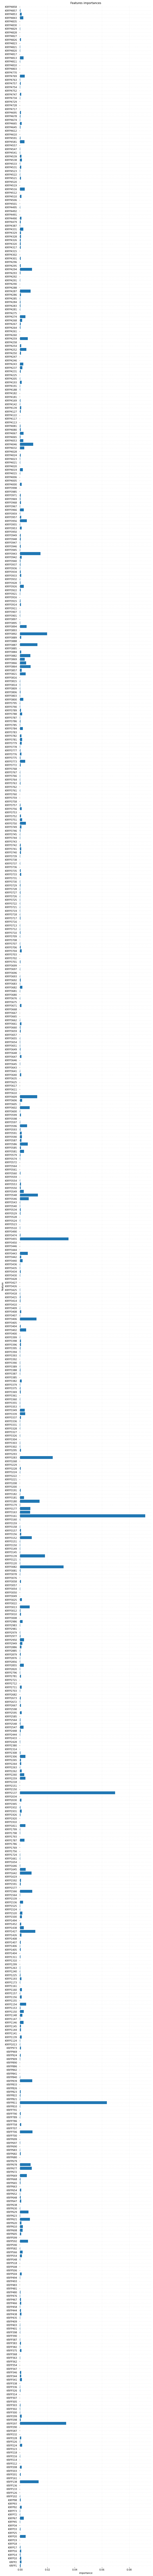

In [20]:
fig, ax = plt.subplots(figsize=(10, 200))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [21]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068
1,Random Forest Regressor,12.766681,648.969400,25.474878,0.373285


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [29]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 3000, 4000],
    'min_child_weight': [80, 95, 120],
    'colsample_bytree': [0.4],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 'min_child_weight': 120, 'n_estimators': 4000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 11.597738216585565
MSE: 586.5876876754057
RMSE: 24.219572409012628
R2 Square 0.43352735201238135 

Base model:
MAE: 10.508681177289226
MSE: 514.0934982110156
RMSE: 22.673630018393958
R2 Square 0.5035355985753974 

Train set:
Tuned model:
MAE: 8.805657430561968
MSE: 297.0343388779757
RMSE: 17.234684182716425
R2 Square 0.6577050330427949 

Base model:
MAE: 5.819261213214838
MSE: 124.14830791190938
RMSE: 11.142185957517913
R2 Square 0.8569345850213049 



In [30]:
params = {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 
          'min_child_weight': 120, 'n_estimators': 4000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 11.597738216585565
MSE: 586.5876876754057
RMSE: 24.219572409012628
R2 Square 0.43352735201238135 

Train set:
MAE: 8.805657430561968
MSE: 297.0343388779757
RMSE: 17.234684182716425
R2 Square 0.6577050330427949 



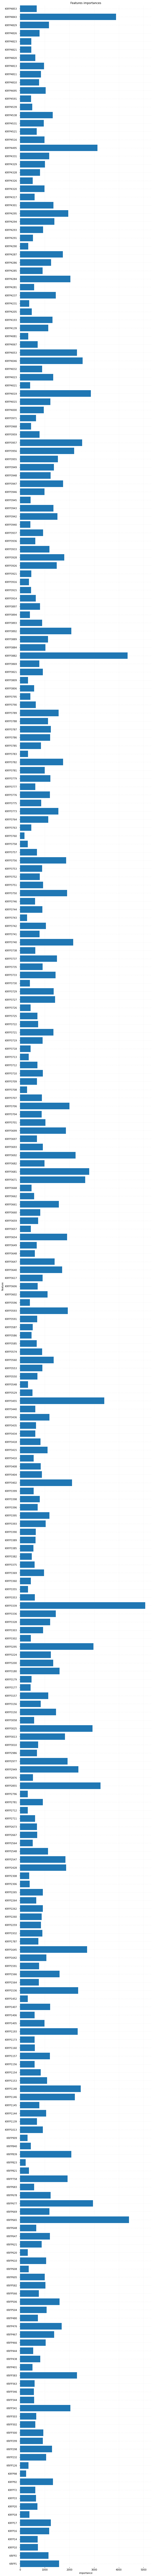

In [31]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 200))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [32]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068
1,Random Forest Regressor,12.766681,648.969400,25.474878,0.373285
2,XGBoost,11.597738,586.587688,24.219572,0.433527


## 5.4. LightGBM

Better results - third model.

In [37]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 2000, 3000],
    'min_child_samples': [30, 55, 65, 100],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.05, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 65, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 11.453737635110933
MSE: 573.6954909915654
RMSE: 23.95194127814206
R2 Square 0.44597745443920467 

Base model:
MAE: 10.9165125141341
MSE: 540.9288926357469
RMSE: 23.257878076809735
R2 Square 0.4776204331892775 

Train set:
Tuned model:
MAE: 8.613939495263287
MSE: 288.6670631592947
RMSE: 16.990204918107807
R2 Square 0.6673472729820107 

Base model:
MAE: 7.68596889595827
MSE: 221.12576853805567
RMSE: 14.870298199365596
R2 Square 0.74518017707638 



In [38]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 65, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 11.450588145857878
MSE: 577.1563480601559
RMSE: 24.02407850595223
R2 Square 0.44263527575195616 

Train set:
MAE: 8.632547696325709
MSE: 289.07862765640084
RMSE: 17.002312420856196
R2 Square 0.6668729963159866 



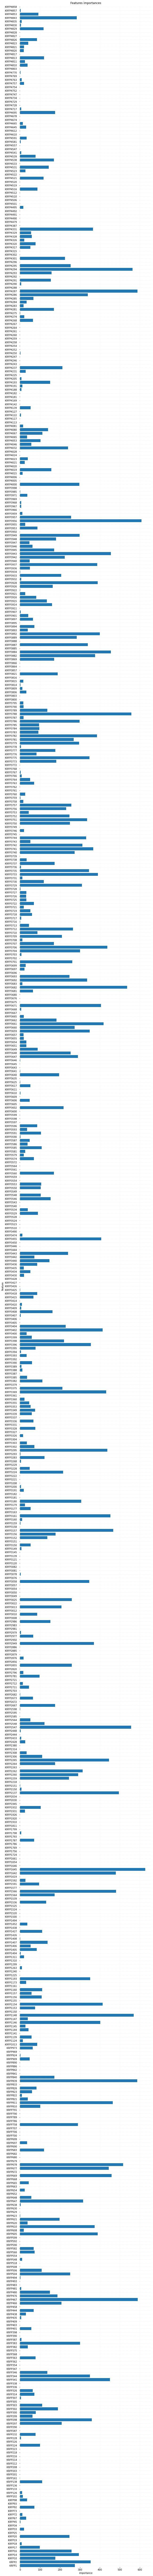

In [39]:
fig, ax = plt.subplots(figsize=(10, 200))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [40]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068
1,Random Forest Regressor,12.766681,648.969400,25.474878,0.373285
2,XGBoost,11.597738,586.587688,24.219572,0.433527
3,LightGBM,11.450588,577.156348,24.024079,0.442635


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [47]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [4, 5, 7, 10, 15],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 10} 

Test set:
Tuned model:
MAE: 11.955646291157812
MSE: 605.9499108266717
RMSE: 24.616049862369707
R2 Square 0.4148290907807305 

Base model:
MAE: 10.916512512017693
MSE: 540.9288915258013
RMSE: 23.257878052948023
R2 Square 0.4776204342611613 

Train set:
Tuned model:
MAE: 10.030881565078174
MSE: 336.5029960853202
RMSE: 18.3440179918501
R2 Square 0.6122223364439239 

Base model:
MAE: 7.685968893317592
MSE: 221.12576829267854
RMSE: 14.870298191115017
R2 Square 0.7451801773591464 



In [48]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 10} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 11.955646291157812
MSE: 605.9499108266717
RMSE: 24.616049862369707
R2 Square 0.4148290907807305 

Train set:
MAE: 10.030881565078174
MSE: 336.5029960853202
RMSE: 18.3440179918501
R2 Square 0.6122223364439239 



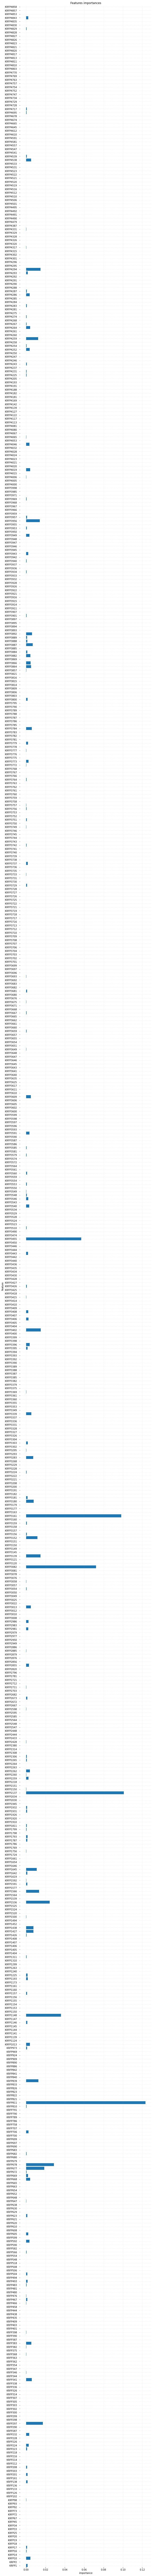

In [50]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 200))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [51]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068
1,Random Forest Regressor,12.766681,648.969400,25.474878,0.373285
2,XGBoost,11.597738,586.587688,24.219572,0.433527
3,LightGBM,11.450588,577.156348,24.024079,0.442635
4,HistGradient Boosting Regressor,11.955646,605.949911,24.616050,0.414829


## 5.6. Support Vector Regression

Better results - fifth model.

In [61]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [15.0, 30.0, 44.0],
    'epsilon': [2.8, 3.8, 6.8, 8.8],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 44.0, 'epsilon': 8.8, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 12.180412693022577
MSE: 737.3905471940581
RMSE: 27.15493596372597
R2 Square 0.28789576623162594 

Base model:
MAE: 12.717450423068975
MSE: 1064.80664758299
RMSE: 32.631375202142344
R2 Square -0.028292706997514516 

Train set:
Tuned model:
MAE: 9.8319528318036
MSE: 508.16775273301874
RMSE: 22.54257644398747
R2 Square 0.4144001505431223 

Base model:
MAE: 11.588416180505503
MSE: 864.0119470766604
RMSE: 29.394080136596557
R2 Square 0.004334172296721506 



In [62]:
params = {'C': 44.0, 'epsilon': 8.8, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 12.180412693022577
MSE: 737.3905471940581
RMSE: 27.15493596372597
R2 Square 0.28789576623162594 

Train set:
MAE: 9.8319528318036
MSE: 508.16775273301874
RMSE: 22.54257644398747
R2 Square 0.4144001505431223 



In [52]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [63]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068
1,Random Forest Regressor,12.766681,648.969400,25.474878,0.373285
2,XGBoost,11.597738,586.587688,24.219572,0.433527
3,LightGBM,11.450588,577.156348,24.024079,0.442635
4,HistGradient Boosting Regressor,11.955646,605.949911,24.616050,0.414829
5,Support Vector Regression,12.180413,737.390547,27.154936,0.287896


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 5.7. Stacking models

### Averaging base models

In [64]:
def average_predictions(X):
    return ((0.20 * rf_best.predict(X)) + \
            (0.25 * xgbr_best.predict(X)) + \
            (0.30 * lgbm_best.predict(X)) + \
            (0.20 * hist_best.predict(X)) + \
            (0.05 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 11.376132564630257
MSE: 577.8423739678351
RMSE: 24.03835214751284
R2 Square 0.44197277478121255 

Train set:
MAE: 8.860748653439064
MSE: 278.69187633026564
RMSE: 16.69406709972934
R2 Square 0.6788424295990277 



In [65]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068
1,Random Forest Regressor,12.766681,648.969400,25.474878,0.373285
2,XGBoost,11.597738,586.587688,24.219572,0.433527
3,LightGBM,11.450588,577.156348,24.024079,0.442635
4,HistGradient Boosting Regressor,11.955646,605.949911,24.616050,0.414829
5,Support Vector Regression,12.180413,737.390547,27.154936,0.287896
6,Averaging base models,11.376133,577.842374,24.038352,0.441973


### Averaging base models with Meta-model

In [66]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [67]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,14.381164,6.015305,8.586364,12.066897,11.939742
1,8.565309,5.011533,4.648015,8.844831,7.611835
2,61.944910,66.156181,68.252083,58.423476,61.199657
3,8.525796,0.316488,0.737154,2.586404,4.839578
4,8.713916,-3.257887,-1.347668,5.298732,-0.244338
...,...,...,...,...,...
2806,15.042153,17.197001,22.904913,21.841333,21.800131
2807,13.966623,10.071982,11.357509,12.591354,10.630233
2808,8.658670,-1.488991,5.691115,7.179593,7.386181
2809,10.422908,15.338779,6.955703,13.777649,16.978321


In [68]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 11.030305537002523
MSE: 556.7963808649602
RMSE: 23.5965332382738
R2 Square 0.46229706677199833 

Train set:
MAE: 7.827333166362614
MSE: 187.0434866555411
RMSE: 13.676384268348894
R2 Square 0.7844557490350619 



In [69]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068
1,Random Forest Regressor,12.766681,648.969400,25.474878,0.373285
2,XGBoost,11.597738,586.587688,24.219572,0.433527
3,LightGBM,11.450588,577.156348,24.024079,0.442635
4,HistGradient Boosting Regressor,11.955646,605.949911,24.616050,0.414829
5,Support Vector Regression,12.180413,737.390547,27.154936,0.287896
6,Averaging base models,11.376133,577.842374,24.038352,0.441973
7,Base models + Meta-model,11.030306,556.796381,23.596533,0.462297


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [70]:
params_rf = {'max_depth': 8, 'n_estimators': 2500} 

params_xgb = {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 
          'min_child_weight': 120, 'n_estimators': 4000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 65, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 
          'subsample': 0.8}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 10}   

params_svr = {'C': 44.0, 'epsilon': 8.8, 'gamma': 'scale', 'kernel': 'rbf'}  

In [71]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 649.5522770068717
Model1 R2: 0.41616364448678067
Model2 MSE: 677.7426288276209
Model2 R2: 0.3908253417045897
Model3 MSE: 678.3498583339025
Model3 R2: 0.39027954627832906
Model4 MSE: 628.8066136855299
Model4 R2: 0.4348104461299812
Model5 MSE: 886.885659999584
Model5 R2: 0.20284154205864546
Average MSE = 704.2674075707018
Average R2 = 0.3669841041316652
-------------- fold 2 --------------
Model1 MSE: 631.0074157818218
Model1 R2: 0.24749187739912915
Model2 MSE: 470.37993795404236
Model2 R2: 0.439048234353401
Model3 MSE: 464.8967122422201
Model3 R2: 0.4455872571651819
Model4 MSE: 519.524007640453
Model4 R2: 0.3804414562209013
Model5 MSE: 609.0202361648115
Model5 R2: 0.2737126964276734
Average MSE = 538.9656619566697
Average R2 = 0.3572563043132574
-------------- fold 3 --------------
Model1 MSE: 360.38320396853493
Model1 R2: 0.41541315864623507
Model2 MSE: 334.5674833243102
Model2 R2: 0.4572895014460404
Model3 MSE: 320.00739697331136
Model3

In [72]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [73]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [75]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,15.514588,3.025102,12.534246,13.904864,18.312298
1,8.238866,4.600130,3.847224,9.071953,8.043103
2,52.937920,57.850842,54.252360,49.955079,52.351659
3,9.653785,-2.374565,-2.331530,6.213668,4.103949
4,8.958658,-3.607671,-1.597152,6.111828,-0.045848
...,...,...,...,...,...
2806,15.033744,18.452997,20.783849,20.374740,26.691119
2807,12.861365,5.820558,9.125336,11.520569,5.967315
2808,8.102874,0.556613,10.931600,6.331118,8.326343
2809,9.363232,10.548792,1.960871,15.742928,15.233762


In [76]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,10.878637,27.869766,30.111903,22.763499,21.510215
1,9.273253,3.397442,2.160000,11.971542,10.202493
2,13.564880,23.723268,28.682462,18.308578,19.791517
3,35.606314,59.968460,55.615853,48.223519,41.146739
4,8.825894,8.439079,8.953486,7.973600,11.219447
...,...,...,...,...,...
699,12.544047,22.594099,19.518066,15.469308,17.891245
700,9.394602,3.231888,0.014849,5.087999,8.222563
701,14.074076,15.463664,14.272957,18.404959,16.211999
702,24.093627,29.084642,28.604380,22.173421,15.942530


In [77]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 11.103840129726562
MSE: 568.4863655370792
RMSE: 23.84295211455744
R2 Square 0.45100795056433873 

Train set:
MAE: 10.757155582689274
MSE: 458.66115716212335
RMSE: 21.416375911020133
R2 Square 0.4714503170629766 



In [78]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,14.175092,700.969522,26.475829,0.323068
1,Random Forest Regressor,12.766681,648.969400,25.474878,0.373285
2,XGBoost,11.597738,586.587688,24.219572,0.433527
3,LightGBM,11.450588,577.156348,24.024079,0.442635
4,HistGradient Boosting Regressor,11.955646,605.949911,24.616050,0.414829
5,Support Vector Regression,12.180413,737.390547,27.154936,0.287896
6,Averaging base models,11.376133,577.842374,24.038352,0.441973
7,Base models + Meta-model,11.030306,556.796381,23.596533,0.462297
8,Base models + Meta-model + cv,11.103840,568.486366,23.842952,0.451008
